# Prelims

In [1]:
# -----------------MAGIC COMMANDS---------------
# magic commands to enable autoreload for imported packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

# -------------------IMPORTS---------------------
# basic project related stuff
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..')) # setting parent_dir in sys.path
sys.path.insert(0, parent_dir) # so that tennis_main can be found as a module

# importing classes and methods
from tennis_main.data import Tennis

# project specific preprocessing methods (based on the MVP notebook)
from tennis_main.data_preprocessing import Tennis_preprocessing
    
# basic EDA
# import ydata_profiling # basic EDA package
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.express as px
from statsmodels.graphics.gofplots import qqplot # quantile-quantile plot for gaussianity check

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

# model evaluation
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, learning_curve
from sklearn.inspection import permutation_importance

# feature evaluation
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# model
from sklearn.linear_model import LogisticRegression

# Data

In [2]:
singles = Tennis().get_singles()

# Concantenating 2010 - 2012 dataframes

In [3]:
singles_2010 = singles[2010]
singles_2011 = singles[2011]
singles_2012 = singles[2012]

In [4]:
singles_df = pd.concat([singles_2010,singles_2011, singles_2012], ignore_index = True)

# Preprocessing the DataFrame

**Some Notes**

- We will drop most features that have minor importance judging by previous efforts. We will then use polynomial features which we will keep up to 3rd degree.
- This is motivated by the fact that we expect the bigger the rankk difference between two players in rank, the more we expect the probability to be in favor of the highest ranking player, which can be modeled by odd degree polynomials only.
- We also use 3 years worth of data instead of 1 like previous times.

In [5]:
preprocessor = Tennis_preprocessing()
singles_df = preprocessor.clean_singles_MVP_one_df(singles_df)
X, y = preprocessor.create_X_and_y(singles_df)

In [6]:
X.columns

Index(['surface', 'draw_size', 'tourney_level', 'player_A_seed',
       'player_A_entry', 'player_A_hand', 'player_A_ht', 'player_A_age',
       'player_B_seed', 'player_B_entry', 'player_B_hand', 'player_B_ht',
       'player_B_age', 'best_of', 'round', 'player_A_rank',
       'player_A_rank_points', 'player_B_rank', 'player_B_rank_points',
       'player_A_is_seeded', 'player_B_is_seeded', 'height_diff', 'age_diff',
       'rank_diff', 'rank_point_diff'],
      dtype='object')

In [7]:
X = X.drop(columns = ["player_A_seed", "player_B_seed", "player_A_rank", "player_A_rank_points", "player_A_ht", "player_A_age",
                     "draw_size", "best_of", "surface", "tourney_level", "player_A_entry", "player_A_hand", "player_B_entry", "player_B_hand","round",
                     "player_B_ht", "player_B_age"])

In [8]:
X_obj = X.select_dtypes(exclude = "number")

## Creating Poly feats

In [9]:
polyfeats = PolynomialFeatures(degree = 3, include_bias = False)
X_poly = polyfeats.fit_transform(X.select_dtypes(include = "number").drop(columns = ["player_A_is_seeded", "player_B_is_seeded"]))

In [10]:
X_poly = pd.DataFrame(X_poly, columns = polyfeats.get_feature_names_out())

## Scaling

As a first approach to see if accuracy will improve, we will use robust scaling for all features and reiterate later

In [11]:
number_cols = X_poly.select_dtypes(include = np.number).columns.to_list()

In [13]:
X_ready = pd.concat([X_poly, X_obj, X[["player_A_is_seeded", "player_B_is_seeded"]]], axis = 1)

In [15]:
feats_to_std_scale =[]# FEATURES_FOR_STANDARD_SCALING
feats_to_rob_scale = number_cols#FEATURES_FOR_ROBUST_SCALING
feats_to_minmax_scale = []

# all feats to be scaled
scaled_feats = feats_to_std_scale + feats_to_rob_scale + feats_to_minmax_scale

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=2010)

# instantiating scalers
rob_scaler = RobustScaler()
# std_scaler = StandardScaler()

# fitting to train set ONLY!
rob_scaler.fit(X_train[feats_to_rob_scale])
# std_scaler.fit(X_train[feats_to_std_scale])

# transforming
X_train[feats_to_rob_scale] = rob_scaler.transform(X_train[feats_to_rob_scale])
X_test[feats_to_rob_scale] = rob_scaler.transform(X_test[feats_to_rob_scale])

# X_train[feats_to_std_scale] = std_scaler.transform(X_train[feats_to_std_scale])
# X_test[feats_to_std_scale] = std_scaler.transform(X_test[feats_to_std_scale])

## Encoding

In [16]:
# features to be encoded
feats_to_encode = X_train.select_dtypes(include = "object").columns.to_list()

# instantiating encoder
ohe = OneHotEncoder(sparse_output = False, drop = "first") # we drop the first category for each feature encoded, to reduce complexity

# fitting to train set ONLY!
ohe.fit(X_train[feats_to_encode])

# transforming
X_train_encoded = ohe.transform(X_train[feats_to_encode])
X_test_encoded = ohe.transform(X_test[feats_to_encode])

# converting into dataframes
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out())
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out())

# resetting indices
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
y_train = y_train.reset_index().drop(columns = "index")
y_test = y_test.reset_index().drop(columns = "index")

# recombining
X_train_combined = pd.concat([X_train[scaled_feats], X_train_encoded_df], axis=1)
X_test_combined = pd.concat([X_test[scaled_feats], X_test_encoded_df], axis=1)

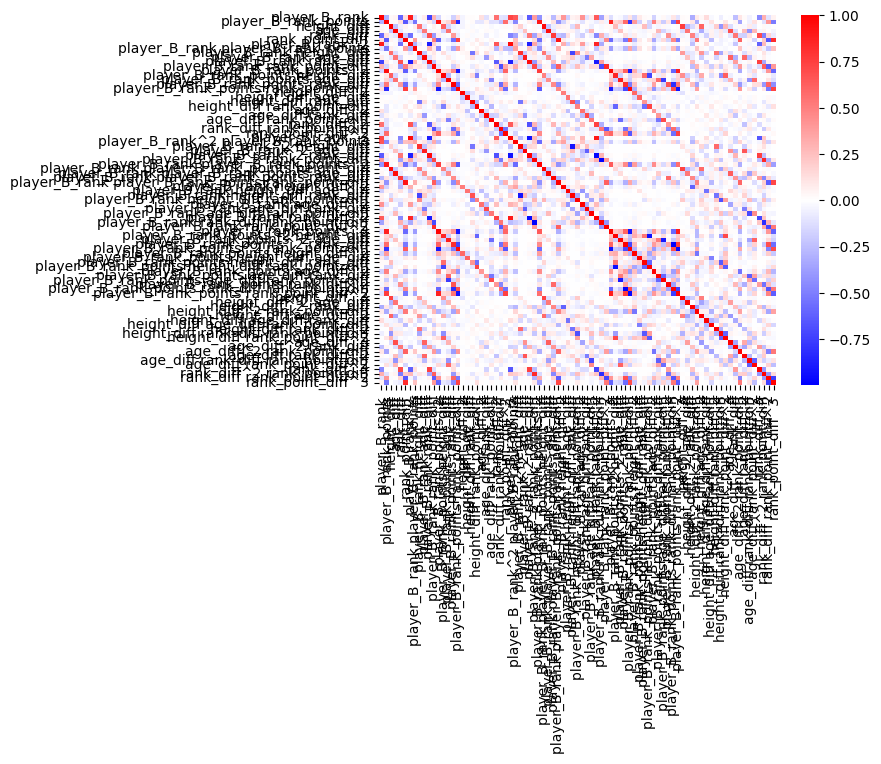

In [17]:
correlation_matrix = X_train_combined.select_dtypes('number').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [18]:
# converting correlation matrix into a df
corr_df = correlation_matrix.stack().reset_index()

# renaming columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# removing self-correlations
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [19]:
# computing absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# showing top 5 most correlated pairs of features
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
4294,player_B_rank_points^2 rank_diff,player_B_rank_points rank_diff rank_point_diff,-0.997332,0.997332
5114,player_B_rank_points rank_diff rank_point_diff,player_B_rank_points^2 rank_diff,-0.997332,0.997332
2702,player_B_rank^2 rank_point_diff,player_B_rank rank_diff rank_point_diff,-0.997325,0.997325
3850,player_B_rank rank_diff rank_point_diff,player_B_rank^2 rank_point_diff,-0.997325,0.997325
1044,player_B_rank_points^2,player_B_rank_points^3,0.978544,0.978544
3996,player_B_rank_points^3,player_B_rank_points^2,0.978544,0.978544
4378,player_B_rank_points^2 rank_point_diff,player_B_rank_points rank_point_diff^2,-0.974057,0.974057
5198,player_B_rank_points rank_point_diff^2,player_B_rank_points^2 rank_point_diff,-0.974057,0.974057
4332,player_B_rank_points^2 rank_point_diff,player_B_rank_points rank_point_diff,0.972008,0.972008
1380,player_B_rank_points rank_point_diff,player_B_rank_points^2 rank_point_diff,0.972008,0.972008


# Model

## CV

In [33]:
# instantiating model
log_reg = LogisticRegression(penalty = 'l2', C = 0.05, solver = 'liblinear', max_iter = 7500)

# cross_val
cv_results = cross_validate(log_reg, X_train_combined, y_train.squeeze(), cv = 5) # converting df to serie so i don't get the annoying warning

In [34]:
cv_results["test_score"].mean()

np.float64(0.6749278581014294)

## Clean Run

In [37]:
# instantiating model
log_reg = LogisticRegression(penalty = 'l2', C = 0.05, solver = 'liblinear', max_iter = 7500)

# training
log_reg.fit(X_train_combined, y_train.squeeze())

# evaluating
log_reg.score(X_test_combined,y_test)

0.6893632683106368

In [23]:
importance = np.abs(log_reg.coef_[0])
feature_importance = pd.Series(importance, index=log_reg.feature_names_in_).sort_values(ascending=False)
feature_importance

rank_diff rank_point_diff^2      1.351984e-02
rank_diff^2 rank_point_diff      1.312003e-02
height_diff^2 rank_point_diff    9.217841e-03
height_diff^3                    7.677735e-03
height_diff^2 rank_diff          6.740779e-03
                                     ...     
height_diff rank_point_diff      1.959195e-05
player_B_rank_points age_diff    3.982747e-06
rank_diff^2                      5.960963e-07
height_diff age_diff             0.000000e+00
age_diff                         0.000000e+00
Length: 83, dtype: float64

In [26]:
pd.DataFrame(feature_importance)[pd.DataFrame(feature_importance)[0]>0].sort_values(by = 0, ascending = False)

,0
rank_diff rank_point_diff^2,1.351984e-02
rank_diff^2 rank_point_diff,1.312003e-02
height_diff^2 rank_point_diff,9.217841e-03
height_diff^3,7.677735e-03
height_diff^2 rank_diff,6.740779e-03
...,...
height_diff^2,3.335843e-05
player_B_rank player_B_rank_points age_diff,2.829826e-05
height_diff rank_point_diff,1.959195e-05
player_B_rank_points age_diff,3.982747e-06


# Learning Curves

In [38]:
# joining X_train and X_test to feed to the learning curves algorithm
X_new = pd.concat([X_train_combined, X_test_combined]).reset_index(drop = True)
y_new = pd.concat([y_train, y_test]).reset_index(drop = True)

# spliting in train sizes up to 70% of the total data
train_sizes = [round(coef*len(X_new)/100) for coef in range(1,72,10)]

# getting scores, sizes and test scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LogisticRegression(penalty = 'l2', C = 0.05, solver = 'liblinear', max_iter = 7500), X=X_new, y=y_new.squeeze(), train_sizes=train_sizes, cv=5)

# means of cv train and test
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Notes

Including polynomial features only marginally improved the accuracy. Using 3 yeras worth of data also had a small effect, as also shown by the learning curves.